In [3]:
pip install openai  

   ---------------------------------------- 0.0/662.0 kB ? eta -:--:--
   ------- -------------------------------- 122.9/662.0 kB 3.6 MB/s eta 0:00:01
   ------------------------ --------------- 399.4/662.0 kB 4.2 MB/s eta 0:00:01
   -------------------------------------- - 634.9/662.0 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 662.0/662.0 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/208.0 kB ? eta -:--:--
   ---------------------------------------- 208.0/208.0 kB 6.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI

# Explicit path to .env file in backend folder
env_path = os.path.join("..", "..", "backend", ".env")  # Two steps back to reach 'backend'
load_dotenv(dotenv_path=env_path)

# Initialize OpenAI client
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OPENAI_API_KEY not found. Check your .env path and contents.")

client = OpenAI(api_key=api_key)

# Load CSV
CSV_PATH = "Data/exercise2.csv"
df = pd.read_csv(CSV_PATH)
df.dropna(how='all', inplace=True)
df.reset_index(drop=True, inplace=True)


In [15]:
def analyze_creativity_with_image_and_text(product_description, image_features):
    prompt = f"""
    Given the product description below and the analysis of its image features, evaluate the creativity on a scale from 0 to 10.
    Creativity should be evaluated based on originality, novelty, and uniqueness.

    Product Description:
    {product_description}

    Image Features (e.g., visual elements, design):
    {image_features}

    Please provide the creativity score based on these two factors (description and image). Return the score as a number between 0 and 10.
    """
    
    response = openai.Completion.create(
        model="gpt-4",  # or whichever model you're using
        prompt=prompt,
        max_tokens=150
    )
    
    creativity_score = response['choices'][0]['text'].strip()
    return creativity_score


In [21]:
import os
import time
import re
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI

# Load API key
load_dotenv(dotenv_path="../../backend/.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Load dataset
CSV_PATH = "Data/exercise2.csv"
df = pd.read_csv(CSV_PATH)
df.dropna(how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

# Functions to build product description blocks
def get_user_products_text(row):
    return f"""
1. {row['product1_name']} — {row['product1_description']} (Price: €{row['product1_suggested_euro']})
2. {row['product2_name']} — {row['product2_description']} (Price: €{row['product2_suggested_euro']})
3. {row['product3_name']} — {row['product3_description']} (Price: €{row['product3_suggested_euro']})
"""

def get_ai_products_text(row):
    return f"""
1. {row['product1_ai_name']} — {row['product1_ai_description']} (Price: €{row['product1_ai_suggested_euro']})
2. {row['product2_ai_name']} — {row['product2_ai_description']} (Price: €{row['product2_ai_suggested_euro']})
3. {row['product3_ai_name']} — {row['product3_ai_description']} (Price: €{row['product3_ai_suggested_euro']})
"""

# ChatGPT call and scoring logic
def analyze_idea_set(product_text):
    prompt = f"""
Evaluate the following three car interior product ideas and return three scores from 0 (low) to 10 (high):

1. Creativity — How original and imaginative are the ideas?
2. Novelty — How different are the ideas from common car accessories?
3. Feasibility — How practical and realistically buildable are these ideas?

Respond only in this JSON format:
{{
  "creativity": x,
  "novelty": y,
  "feasibility": z
}}

Ideas:
{product_text}
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=150
        )
        text = response.choices[0].message.content.strip()

        # Extract using regex for robustness
        pattern = r'"?creativity"?\s*:\s*(\d+).*?"?novelty"?\s*:\s*(\d+).*?"?feasibility"?\s*:\s*(\d+)'
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)

        if match:
            return {
                "creativity": int(match.group(1)),
                "novelty": int(match.group(2)),
                "feasibility": int(match.group(3)),
            }
        else:
            return {
                "creativity": "ParseError",
                "novelty": "ParseError",
                "feasibility": "ParseError",
            }

    except Exception as e:
        return {
            "creativity": f"Error: {e}",
            "novelty": "-",
            "feasibility": "-"
        }

# Add new columns to hold scores
df["user_creativity"] = ""
df["user_novelty"] = ""
df["user_feasibility"] = ""
df["ai_creativity"] = ""
df["ai_novelty"] = ""
df["ai_feasibility"] = ""

# Analyze each row
for idx, row in df.iterrows():
    print(f"\n--- Row {idx + 1} ---")

    if pd.isna(row["product1_name"]) or pd.isna(row["product1_ai_name"]):
        print("Skipping incomplete row.")
        continue

    user_text = get_user_products_text(row)
    ai_text = get_ai_products_text(row)

    user_scores = analyze_idea_set(user_text)
    time.sleep(1)
    ai_scores = analyze_idea_set(ai_text)
    time.sleep(1)

    print(f"User-designed scores → Creativity: {user_scores['creativity']}, Novelty: {user_scores['novelty']}, Feasibility: {user_scores['feasibility']}")
    print(f"AI-designed scores   → Creativity: {ai_scores['creativity']}, Novelty: {ai_scores['novelty']}, Feasibility: {ai_scores['feasibility']}")

    # Save to dataframe
    df.at[idx, "user_creativity"] = user_scores["creativity"]
    df.at[idx, "user_novelty"] = user_scores["novelty"]
    df.at[idx, "user_feasibility"] = user_scores["feasibility"]
    df.at[idx, "ai_creativity"] = ai_scores["creativity"]
    df.at[idx, "ai_novelty"] = ai_scores["novelty"]
    df.at[idx, "ai_feasibility"] = ai_scores["feasibility"]

# Save updated dataset
OUTPUT_PATH = "Data/exercise2_scored.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ All scores saved to: {OUTPUT_PATH}")



--- Row 1 ---
Skipping incomplete row.

--- Row 2 ---
User-designed scores → Creativity: 7, Novelty: 6, Feasibility: 9
AI-designed scores   → Creativity: 7, Novelty: 5, Feasibility: 9

--- Row 3 ---
User-designed scores → Creativity: 7, Novelty: 6, Feasibility: 8
AI-designed scores   → Creativity: 9, Novelty: 10, Feasibility: 7

--- Row 4 ---
Skipping incomplete row.

--- Row 5 ---
Skipping incomplete row.

--- Row 6 ---
User-designed scores → Creativity: 8, Novelty: 7, Feasibility: 7
AI-designed scores   → Creativity: 7, Novelty: 8, Feasibility: 7

--- Row 7 ---
User-designed scores → Creativity: 8, Novelty: 8, Feasibility: 6
AI-designed scores   → Creativity: 8, Novelty: 7, Feasibility: 7

--- Row 8 ---
Skipping incomplete row.

--- Row 9 ---
User-designed scores → Creativity: ParseError, Novelty: ParseError, Feasibility: ParseError
AI-designed scores   → Creativity: 9, Novelty: 8, Feasibility: 6

--- Row 10 ---
Skipping incomplete row.

--- Row 11 ---
User-designed scores → Creativ


=== Average Scores ===

User Design Averages:
  Creativity: 7.53
  Novelty: 7.12
  Feasibility: 6.94

AI Design Averages:
  Creativity: 7.53
  Novelty: 6.59
  Feasibility: 7.47


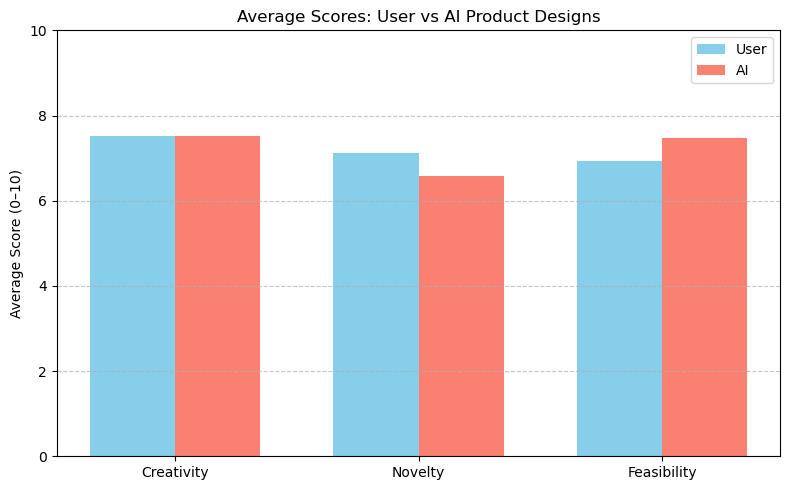

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the scored CSV
df = pd.read_csv("Data/exercise2_scored.csv")

# Convert score columns to numeric (some may have 'Error' strings)
score_columns = [
    "user_creativity", "user_novelty", "user_feasibility",
    "ai_creativity", "ai_novelty", "ai_feasibility"
]
df[score_columns] = df[score_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaNs in score columns
df_clean = df.dropna(subset=score_columns)

# Compute average scores
averages = {
    "User": {
        "Creativity": round(df_clean["user_creativity"].mean(), 2),
        "Novelty": round(df_clean["user_novelty"].mean(), 2),
        "Feasibility": round(df_clean["user_feasibility"].mean(), 2),
    },
    "AI": {
        "Creativity": round(df_clean["ai_creativity"].mean(), 2),
        "Novelty": round(df_clean["ai_novelty"].mean(), 2),
        "Feasibility": round(df_clean["ai_feasibility"].mean(), 2),
    }
}

# Print the averages
print("\n=== Average Scores ===")
for group, scores in averages.items():
    print(f"\n{group} Design Averages:")
    for metric, score in scores.items():
        print(f"  {metric}: {score}")

# Prepare data for plotting
labels = ["Creativity", "Novelty", "Feasibility"]
user_scores = [averages["User"][k] for k in labels]
ai_scores = [averages["AI"][k] for k in labels]

x = range(len(labels))
width = 0.35

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x, user_scores, width=width, label="User", color="skyblue")
plt.bar([p + width for p in x], ai_scores, width=width, label="AI", color="salmon")
plt.xticks([p + width / 2 for p in x], labels)
plt.ylabel("Average Score (0–10)")
plt.title("Average Scores: User vs AI Product Designs")
plt.ylim(0, 10)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


100%|██████████| 25/25 [00:00<00:00, 57614.07it/s]


=== Creativity Scores for Sketch Images ===
                         sketch_upload_path_after sketch_creativity_score
0                                             NaN                      NA
1    user_sketch_images_final/19_sketch_after.jpg                      NA
2                                             NaN                      NA
3     user_sketch_images_final/7_sketch_after.PNG                      NA
4                                             NaN                      NA
5    user_sketch_images_final/20_sketch_after.jpg                      NA
6    user_sketch_images_final/17_sketch_after.jpg                      NA
7                                             NaN                      NA
8    user_sketch_images_final/14_sketch_after.jpg                      NA
9                                             NaN                      NA
10   user_sketch_images_final/23_sketch_after.jpg                      NA
11    user_sketch_images_final/9_sketch_after.png                  

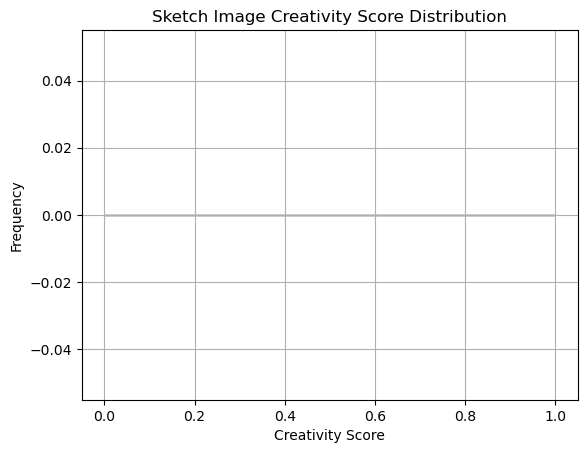

In [24]:
import os
import openai
import pandas as pd
from dotenv import load_dotenv
from PIL import Image
import base64
import requests
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt

# === Load environment and API key ===
load_dotenv("../../backend/.env")
openai.api_key = os.getenv("OPENAI_API_KEY")

# === Load your CSV data ===
df = pd.read_csv("Data/exercise2.csv")
df.dropna(how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

# === Paths to sketch images (user final sketches only) ===
IMAGE_FOLDER = "Results/Exercise2/user_sketch_images_final"

# === Helper: Load image and convert to base64 ===
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

# === Helper: Analyze creativity using GPT-4 with image embedding ===
def analyze_image_creativity_with_gpt(image_path):
    base64_image = encode_image_to_base64(image_path)

    try:
        response = openai.chat.completions.create(
            model="gpt-4-vision-preview",
            messages=[
                {"role": "system", "content": "You are an expert designer evaluating creativity in product sketches."},
                {"role": "user", "content": [
                    {"type": "text", "text": """
Evaluate the creativity of the following sketch image of a car interior product. 
Rate its creativity from 0 (not creative) to 10 (very creative), considering its novelty, originality, and imaginative design.
Return only the numeric score.
"""},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]}
            ],
            max_tokens=10
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error: {e}"

# === Run for all available sketch images ===
image_scores = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_name = os.path.basename(str(row["sketch_upload_path_after"]))
    img_path = os.path.join(IMAGE_FOLDER, img_name)

    if os.path.exists(img_path):
        score = analyze_image_creativity_with_gpt(img_path)
    else:
        score = "NA"

    image_scores.append(score)

# === Save results back into the DataFrame ===
df["sketch_creativity_score"] = image_scores
df.to_csv("Data/exercise2_with_sketch_scores.csv", index=False)

# === Optional: Print and plot scores ===
print("\n=== Creativity Scores for Sketch Images ===")
print(df[["sketch_upload_path_after", "sketch_creativity_score"]])

# Filter and plot valid numeric scores
valid_scores = pd.to_numeric(df["sketch_creativity_score"], errors='coerce').dropna()
plt.hist(valid_scores, bins=10, color='skyblue', edgecolor='black')
plt.title("Sketch Image Creativity Score Distribution")
plt.xlabel("Creativity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [27]:
import os
import base64
import pandas as pd
import glob
from PIL import Image
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variable
load_dotenv("../../backend/.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Set up paths
CSV_PATH = "Data/exercise2.csv"
IMAGE_FOLDER = "Results/Exercise2/user_sketch_images_final"
OUTPUT_CSV = "Results/sketch_creativity_scores.csv"

# Load data
df = pd.read_csv(CSV_PATH)
df['sketch_creativity_score'] = "NA"

# Helper function: Find image ignoring case
def find_image_case_insensitive(filename):
    name_root = os.path.splitext(os.path.basename(filename))[0]
    matches = glob.glob(f"{IMAGE_FOLDER}/**/*{name_root}.*", recursive=True)
    for m in matches:
        try:
            # Verify it's a real image
            with Image.open(m) as im:
                im.verify()
            return m
        except Exception:
            continue
    return None

# Helper: Convert image to base64
def image_to_base64(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

# Analyze image creativity using GPT-4-Vision
def get_creativity_score(base64_image):
    try:
        response = client.chat.completions.create(
            model="gpt-4-vision-preview",
            messages=[
                {"role": "user", "content": [
                    {"type": "text", "text": "Rate the creativity of this sketch for a car interior product on a scale from 0 (not creative) to 10 (highly creative). Respond with just a single number."},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]}
            ],
            max_tokens=10
        )
        score = response.choices[0].message.content.strip()
        return score
    except Exception as e:
        print("API error:", e)
        return "NA"

# Process each sketch
for i, row in tqdm(df.iterrows(), total=len(df)):
    path = row.get('sketch_upload_path_after')
    if pd.isna(path):
        continue

    img_path = find_image_case_insensitive(path)
    if img_path is None:
        print(f"Image not found or unreadable: {path}")
        continue

    try:
        base64_img = image_to_base64(img_path)
        score = get_creativity_score(base64_img)
        df.at[i, 'sketch_creativity_score'] = score
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        df.at[i, 'sketch_creativity_score'] = "NA"

# Ensure the output directory exists
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

# Save results
df.to_csv(OUTPUT_CSV, index=False)
print("\n=== Creativity Scores for Sketch Images ===")
print(df[['sketch_upload_path_after', 'sketch_creativity_score']])


100%|██████████| 25/25 [00:00<00:00, 1479.12it/s]

Image not found or unreadable: user_sketch_images_final/19_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/7_sketch_after.PNG
Image not found or unreadable: user_sketch_images_final/20_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/17_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/14_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/23_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/9_sketch_after.png
Image not found or unreadable: user_sketch_images_final/16_sketch_after.jpeg
Image not found or unreadable: user_sketch_images_final/15_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/11_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/10_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/30_sketch_after.jpg
Image not found or unreadable: user_sketch_images_final/24_sketch_after.jpg
Image not fou